Last year we added functionality to the RDKit to allow searching in synthon, or combinatorial library spaces. Dave Cosgrove [did a blog post](https://greglandrum.github.io/rdkit-blog/posts/2024-12-03-introducing-synthon-search.html) on this a while ago and there also a [tutorial in the docs](https://www.rdkit.org/docs/GettingStartedInPython.html#searching-synthon-spaces). 

I've been asked a few times how one can create a synthon space from either a set of compounds or a set of reactions and building blocks. This post will focus on the first use case: creating a synthon space from the fragments created by applying BRICS fragmentation to a set of ChEMBL compounds. I will try to do a post covering the other use case in the not-too-distant future.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import BRICS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdSynthonSpaceSearch

import rdkit
print(rdkit.__version__)

2025.09.3


# The synthon space input file

Let's start by looking at what the synthon space input file looks like:

In [2]:
# snipped from the freedom space input
open('./blah.txt','w+').write('''SMILES	synton_id	synton#	reaction_id	release
Clc1ccc(-c2cnc(N[U])s2)cc1	6	1	a1	3
O=[N+]([O-])c1cccc(N[U])c1O	10	1	a1	3
O=C([U])c1sc2cc(Cl)ccc2c1Cl	31	2	a1	3
COc1cccc(O)c1C(=O)[U]	86	2	a1	3
''')

189

There's more information about the format and how searches work [in the docs](https://www.rdkit.org/docs/GettingStartedInPython.html#how-it-works).

Here's a quick demo on using the file:

In [3]:
spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadTextFile('blah.txt')
spc.GetNumProducts()

4

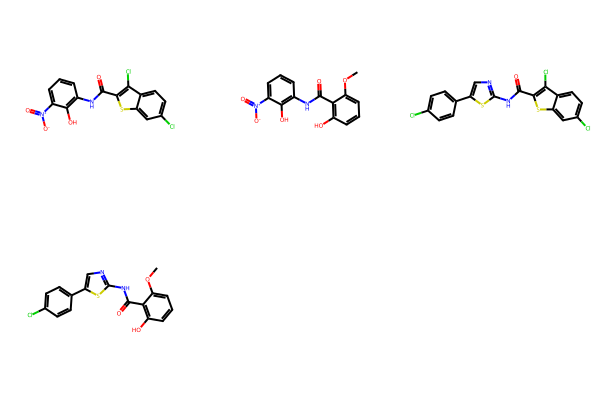

In [4]:
res = spc.SubstructureSearch(Chem.MolFromSmarts('CN'))
Draw.MolsToGridImage(res.GetHitMolecules())

# BRICS decomposition:

I did a post earlier this year with a [tutorial on BRICS decomposition](https://greglandrum.github.io/rdkit-blog/posts/2025-08-15-BRICS-tutorial.html), so I won't get into a lot of detail here.

Here's a ChEMBL molecule we'll work with:

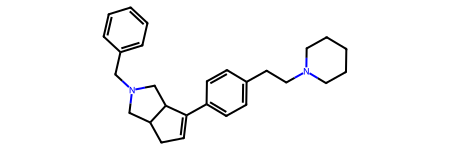

In [5]:
m = Chem.MolFromSmiles('C1=C(c2ccc(CCN3CCCCC3)cc2)C2CN(Cc3ccccc3)CC2C1 CHEMBL256225')
m

And this is what we get when we do a BRICS decomposition:

In [6]:
BRICS.BRICSDecompose(m)

{'[16*]c1ccccc1',
 '[4*]CC[8*]',
 '[4*]C[8*]',
 '[5*]N1CC2CC=C(c3ccc([16*])cc3)C2C1',
 '[5*]N1CCCCC1'}

The synthon space search code works by combining multiple building blocks to form a compound in a single "reaction" step, and it's unhappy if you have dummy atoms/attachment points leftover after that step, So these fragments are too small to be useful in sython searching.

Fortunately, we can have the BRICS decomposition give us partial decomposition results along with the final results:

In [7]:
BRICS.BRICSDecompose(m,keepNonLeafNodes=True,minFragmentSize=2)

{'C1=C(c2ccc(CCN3CCCCC3)cc2)C2CN(Cc3ccccc3)CC2C1',
 '[16*]c1ccc(C2=CCC3CN(Cc4ccccc4)CC23)cc1',
 '[16*]c1ccccc1',
 '[4*]CC[8*]',
 '[4*]CCc1ccc(C2=CCC3CN(C[8*])CC23)cc1',
 '[4*]CCc1ccc(C2=CCC3CN(Cc4ccccc4)CC23)cc1',
 '[4*]CCc1ccc(C2=CCC3CN([5*])CC23)cc1',
 '[4*]Cc1ccccc1',
 '[5*]N1CC2CC=C(c3ccc(CCN4CCCCC4)cc3)C2C1',
 '[5*]N1CC2CC=C(c3ccc([16*])cc3)C2C1',
 '[5*]N1CCCCC1',
 '[8*]CCN1CCCCC1',
 '[8*]CN1CC2CC=C(c3ccc(CCN4CCCCC4)cc3)C2C1',
 '[8*]CN1CC2CC=C(c3ccc([16*])cc3)C2C1'}

What we'll do here is pick out all of the fragments that have two attachment points to use as core synthons for a reaction and then provide all the single-attachment point fragments that are compatible with those two attachment points as the other partners in a reaction.

So in this case one "reaction" would be around the core `[4*]CCc1ccc(C2=CCC3CN(C[8*])CC23)cc1` as synthon 1. We would we'd provide all of the single-attachment fragments that can connect to attachment point `[4*]` (in this set of fragments that's only `[5*]`) as synthon 2, and all of the single-attachment fragnets that can connect to attachment point `[8*]` (here that's `[16*]`) as synthon 3.

Because the synthon code connects attachment points with the same label, we need to transform all of the `[5*]`s into `[4*]`s and all of the `[16*]`s into `[8*]`s to give this:
```
SMILES	synton_id	synton#	reaction_id	release
[4*]CCc1ccc(C2=CCC3CN(C[8*])CC23)cc1	1	1	r1	1
[4*]N1CCCCC1	2	2	r1	1
[4*]Cc1ccccc1	3	2	r1	1
[4*]N1CC2CC=C(c3ccc(CCN4CCCCC4)cc3)C2C1	4	2	r1	1
[4*]CCc1ccc(C2=CCC3CN(Cc4ccccc4)CC23)cc1	5	2	r1	1
[8*]c1ccc(C2=CCC3CN(Cc4ccccc4)CC23)cc1	6	3	r1	1
[8*]CN1CC2CC=C(c3ccc(CCN4CCCCC4)cc3)C2C1	7	3	r1	1
[8*]CCN1CCCCC1	8	3	r1	1
[8*]c1ccccc1	9	3	r1	1
```

Automating this to handle a set of molecules doesn't require a massive amount of code:

In [8]:
from collections import defaultdict
import re
from rdkit.Chem import BRICS
import copy
import logging

def get_connectors():
    ''' read all the BRICS "reaction" definitions and build a dict mapping
      connector type -> types it can connect to
    '''
    connectors = defaultdict(list)
    for defs in BRICS.reactionDefs:
        for i,j,b in defs:
            if b!='-':
                continue
            connectors[i+'*'].append(j+'*')
            connectors[j+'*'].append(i+'*')
    # remove duplicates and convert to a standard dict
    res = {}
    for k,v in connectors.items():
        res[k] = list(set(v))
    return res

def get_synthons(mol):
    frags = BRICS.BRICSDecompose(mol,keepNonLeafNodes=True,minFragmentSize=2)
    # remove anything with 7 in it since those are attached with double bonds
    # and we don't handle those:
    frags = [x for x in frags if '[7*' not in x]
    cnts = [(x,x.count('*')) for x in frags]
    ones = list(sorted([x for x,cnt in cnts if cnt==1],key=lambda x:len(x)))
    twos = list(sorted([x for x,cnt in cnts if cnt==2],key=lambda x:len(x)))
    return twos,ones

def get_possibles(rlabel,frags,connectors):
    res = []
    poss = connectors[rlabel]
    rlabel = '['+rlabel
    for smi in frags:
        if rlabel in smi:
            res.append(smi)
            continue
        for lbl in poss:
            lbl = '['+lbl
            if lbl in smi:
                nsmi = smi.replace(lbl,rlabel)
                res.append(nsmi)
                break
    return res

def get_rs(core):
    return re.findall(r'\[(.*?\*)\]',core)

def generate_space(mols,fname):
    connectors = get_connectors()
    with open(fname,'w+') as outf:
        nWritten = 0
        nRxns = 0
        for i,mol in enumerate(mols):
            twos,ones = get_synthons(mol)
            if not len(twos):
                continue
            nWritten,nRxns = generate_reactions(outf,twos,ones,connectors,nWritten,nRxns,writeHeader=(not nWritten))
    return nWritten,nRxns


def generate_reactions(outf,allTwos,allOnes,connectors,nWritten=0,nRxns=0,writeHeader=True):
    if writeHeader:
        outf.write('\t'.join(['SMILES','synton_id','synton#','reaction_id','release'])+'\n')
    for rs,twos in allTwos.items():
        assert len(rs)==2
        # do we have the same label twice?
        newrs = rs[:]
        if len(set(rs)) != 2:
            rs = list(rs)
            rlabel = rs[0]
            newlabel = rlabel.replace('*','00*')
            newrs = (newlabel,rs[1])
            connectors = copy.deepcopy(connectors)
            connectors[newlabel] = connectors[rlabel]
            rs = tuple(rs)
        for core in twos:
            if newrs != rs:
                core = core.replace(rs[0],newrs[0],1)
            outf.write(f'{core}\t{nWritten+1}\t1\tr{nRxns+1}\t1\n')
            nWritten += 1
        ones = allOnes[rs]
        for j,r in enumerate(newrs):
            for p in get_possibles(r,ones,connectors):
                outf.write(f'{p}\t{nWritten+1}\t{j+2}\tr{nRxns+1}\t1\n')
                nWritten += 1
        nRxns += 1
    return nWritten,nRxns

def generate_space(mols,fname):
    connectors = get_connectors()
    allOnes = defaultdict(set)
    allTwos = defaultdict(set)
    for mol in mols:
        twos,ones = get_synthons(mol)
        for two in twos:
            rs = tuple(sorted(get_rs(two)))
            if len(rs) != 2:
                logger.warning(f'core {two} does not have two attachment points')
            allTwos[rs].add(two)
            allOnes[rs] = allOnes[rs].union(ones)
    with open(fname,'w+') as outf:
        nWritten,nRxns = generate_reactions(outf,allTwos,allOnes,connectors)
    return nWritten,nRxns

Try that out on two molecules:

In [9]:
sample1 = Chem.MolFromSmiles('C1=C(c2ccc(CCN3CCCCC3)cc2)C2CN(Cc3ccccc3)CC2C1 CHEMBL256225')
sample2 = Chem.MolFromSmiles('C1=C(c2ccc(CCN3CCCCCC3)cc2)C2CN(Cc3ccccc3)CC2C1 madeup')
nWritten,nRxns=generate_space([sample1,sample2],'blah2.txt')
print(nWritten,nRxns)

65 4


In [10]:
!head blah2.txt

SMILES	synton_id	synton#	reaction_id	release
[4*]CCc1ccc(C2=CCC3CN(C[8*])CC23)cc1	1	1	r1	1
[4*]CC[8*]	2	1	r1	1
[4*]N1CCCCC1	3	2	r1	1
[4*]Cc1ccccc1	4	2	r1	1
[4*]N1CC2CC=C(c3ccc(CCN4CCCCC4)cc3)C2C1	5	2	r1	1
[4*]N1CCCCCC1	6	2	r1	1
[4*]CCc1ccc(C2=CCC3CN(Cc4ccccc4)CC23)cc1	7	2	r1	1
[4*]N1CC2CC=C(c3ccc(CCN4CCCCCC4)cc3)C2C1	8	2	r1	1
[8*]CCN1CCCCC1	9	3	r1	1


Notice in the above that we have combined the two cores that have attachment points `[4*]` and `[8*]` into a single reaction, `r1`. This makes the resulting synthon space smaller and more efficient to search.

Ok, let's do more molecules. I'll use the set of very active molecules from ChEMBL36 that I put together in an [earlier blog post](https://greglandrum.github.io/rdkit-blog/posts/2025-10-31-how-long-does-it-take.html).

In [11]:
lines = open('../data/chembl36_very_active.txt','r').readlines()
# header:
lines.pop(0)
keep = []
for l in lines:
    if '[' not in l:
        keep.append(l.strip().split()[1])
len(keep)

3074

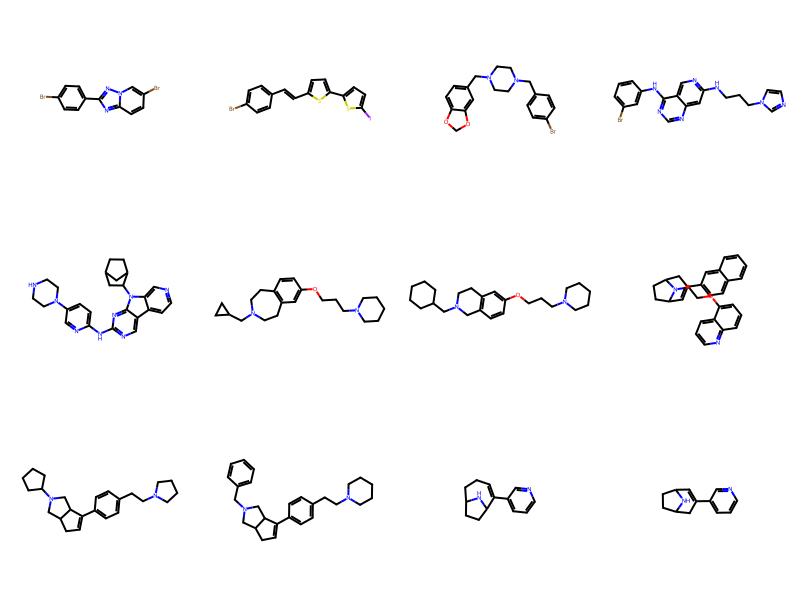

In [12]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in keep[:12]],molsPerRow=4)

Generate a synthon space for the first 300 of the ChEMBL compounds:

In [13]:
first = [Chem.MolFromSmiles(x) for x in keep[:300]]

fname = './results/actives_space.txt'
nwritten,nrxns = generate_space(first,fname)
print(f'{nwritten} synthons in {nrxns} reactions')

spc = rdSynthonSpaceSearch.SynthonSpace()
spc.ReadTextFile(fname)
print(f'{rdSynthonSpaceSearch.FormattedIntegerString(spc.GetNumProducts())} products in space')

23789 synthons in 79 reactions
253 702 889 products in space


Here's what the file looks like:

In [14]:
!head ./results/actives_space.txt

SMILES	synton_id	synton#	reaction_id	release
[500*]NC(=O)N[5*]	1	1	r1	1
[500*]NC(=O)NC1CCN(C(=O)c2ccc(C(=O)N[5*])cc2)CC1	2	1	r1	1
[500*]Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)C(C)N([5*])CC2	3	1	r1	1
[500*]Nc1cc2cc(C3CCN([5*])CC3)c(C)cc2cn1	4	1	r1	1
[500*]Nc1nc2c(nc1N1CCC(Oc3ccc(F)cc3F)CC1)CN([5*])C(C)C2	5	1	r1	1
[500*]NCCCN1CCN(CCCN[5*])CC1	6	1	r1	1
[500*]Nc1cccc(CCN2CCN([5*])CC2)c1	7	1	r1	1
[500*]Nc1ccc(S(=O)(=O)N[5*])cc1F	8	1	r1	1
[500*]NC(=O)c1ccc(-c2cnc3c(N[5*])cc(C(F)(F)c4cccc(F)c4)nn23)cc1C	9	1	r1	1


Let's do a few searches:

1000 results


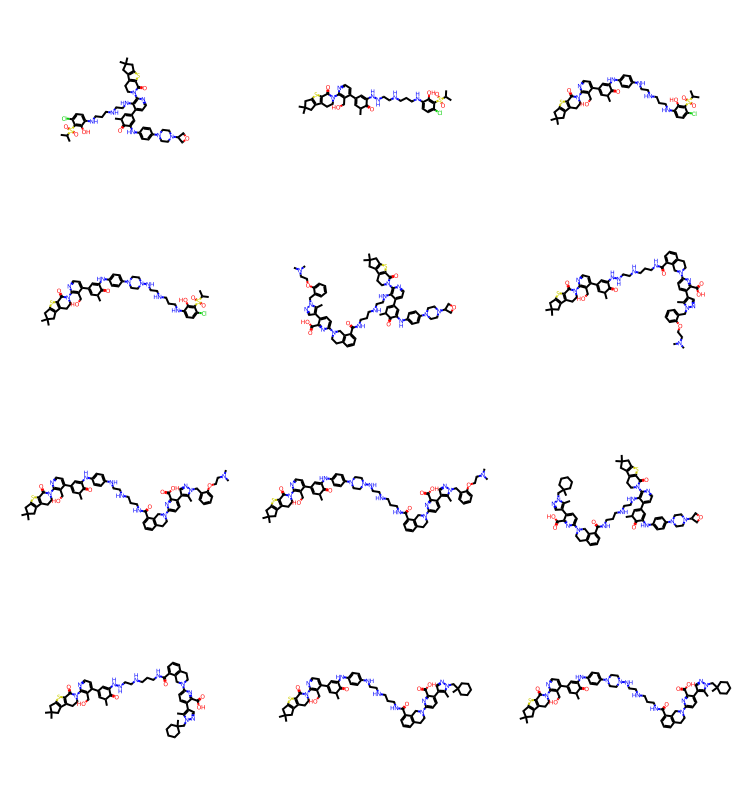

In [16]:
res = spc.SubstructureSearch(Chem.MolFromSmarts('c1cccs1'))
resMols = res.GetHitMolecules()
print(f'{len(resMols)} results')
Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

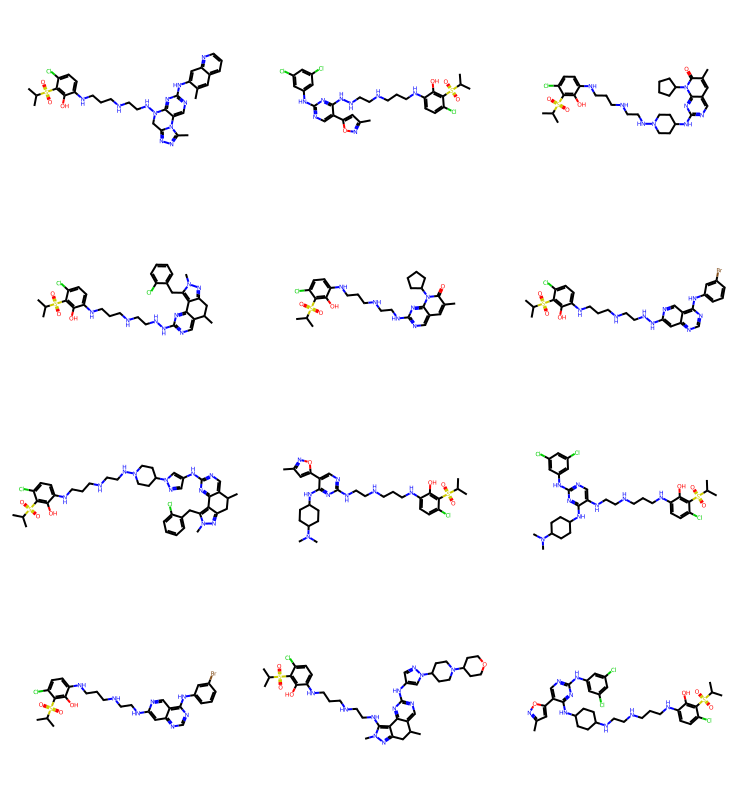

In [19]:
res = spc.SubstructureSearch(Chem.MolFromSmarts('c1ncncc1'))
resMols = res.GetHitMolecules()

Draw.MolsToGridImage(resMols[:12],subImgSize=(250,200)) if len(resMols) else None

It's nicer to sort by increasing molecular size:

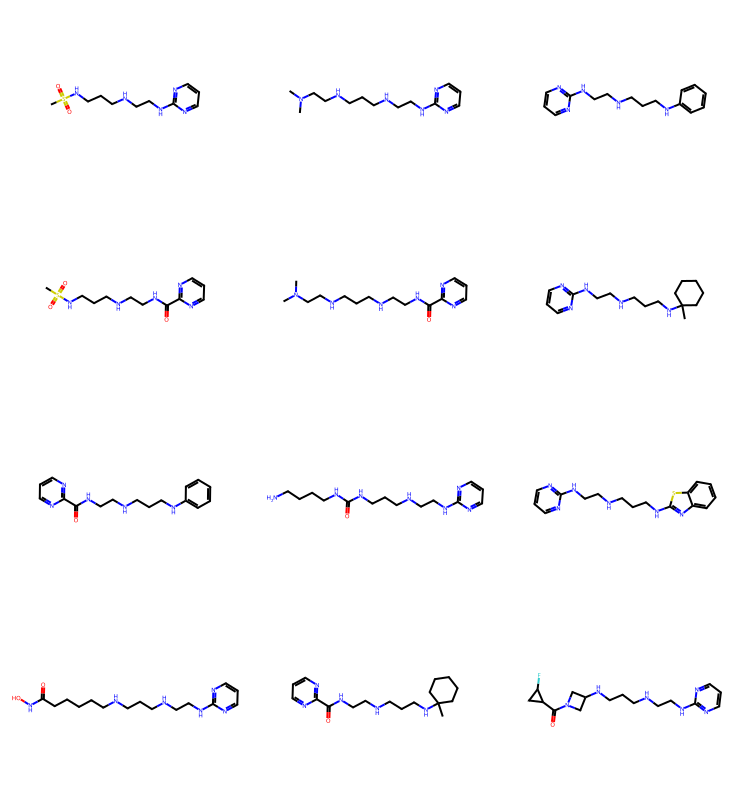

In [21]:
tms = list(sorted(resMols,key=lambda x:x.GetNumHeavyAtoms()))
Draw.MolsToGridImage(tms[:12],subImgSize=(250,200)) if len(tms) else None


As we saw in the [blog post on BRICS](https://greglandrum.github.io/rdkit-blog/posts/2025-08-15-BRICS-tutorial.html), you can get some odd molecules by putting together BRICS fragments, but there are plenty of results in there that still look reasonable.